In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]


In [3]:
EXP_NAME

'exp053'

## read data

In [4]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v4/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v4/test_10000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)


In [5]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32, 'timediff':np.int})
test_df = test_df.astype({'timestamp':int})
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + '_' + train_df['timestamp'].astype(str)

In [6]:
oof = pd.read_csv('oof.csv')

In [7]:
oof = oof.sort_values('id').reset_index(drop=True)
oof

,rssi_0,rssi_1,rssi_2,rssi_3,rssi_4,rssi_5,rssi_6,rssi_7,rssi_8,rssi_9,...,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,27,48,50,52,53,55,57,57,57,57,...,113.61539,156.634800,B1,5e1580d1f4c3420006d520e4,0,5a0546857ecc773753327266,112.473070,159.216610,0.000000,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
1,35,45,47,48,49,49,49,49,50,50,...,112.65588,156.358200,B1,5e1580d1f4c3420006d520e4,0,5a0546857ecc773753327266,111.442930,161.565340,0.000000,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
2,31,33,46,49,50,52,53,55,57,57,...,111.93626,156.150770,B1,5e1580d1f4c3420006d520e4,0,5a0546857ecc773753327266,110.789406,158.411990,0.000000,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
3,35,46,50,50,50,52,52,52,53,53,...,110.97676,155.874180,B1,5e1580d1f4c3420006d520e4,0,5a0546857ecc773753327266,107.481990,160.047210,0.000000,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
4,40,42,46,50,53,53,53,53,53,53,...,110.01726,155.597580,B1,5e1580d1f4c3420006d520e4,0,5a0546857ecc773753327266,107.953660,161.444120,0.000000,5a0546857ecc773753327266_5e1580d1f4c3420006d52...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240871,52,52,60,66,67,68,69,69,70,71,...,128.92522,109.018060,F7,5dcfb393878f3300066c70a6,23,5dc8cea7659e181adb076a3f,121.309610,117.209440,1.944064,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...
240872,48,53,59,63,63,64,69,70,71,72,...,130.64580,110.522870,F7,5dcfb393878f3300066c70a6,23,5dc8cea7659e181adb076a3f,123.721240,118.052630,2.076902,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...
240873,49,56,62,62,63,64,68,69,69,71,...,132.87224,112.610954,F7,5dcfb393878f3300066c70a6,23,5dc8cea7659e181adb076a3f,130.722800,122.199844,2.570297,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...
240874,53,55,61,64,65,66,66,67,68,70,...,133.95160,113.695820,F7,5dcfb393878f3300066c70a6,23,5dc8cea7659e181adb076a3f,131.198750,120.969740,2.508358,5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...


In [8]:
oof['id']

0              0
1              1
2              2
3              3
4              4
           ...  
240871    240871
240872    240872
240873    240873
240874    240874
240875    240875
Name: id, Length: 240876, dtype: int64

## スコア(error)を計算

In [9]:
def mean_position_error(xhat, yhat, x, y):
    return np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2))

In [10]:
def metric(row):
    return mean_position_error(row['oof_x'], row['oof_y'], row['x'], row['y'])

In [11]:
oof["error"] = oof.apply(metric, axis=1)

In [12]:
oof['error'].mean()

7.947984427652757

In [13]:
oof.groupby("site_path_timestamp").mean().reset_index().apply(metric, axis=1).mean()

7.353611802641544

In [14]:
thr = 40
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

7.708486562453084
データ数 1156
path数 323


In [15]:
thr = 30
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

7.48043582023619
データ数 3221
path数 743


In [16]:
thr = 20
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

6.865450129778465
データ数 11856
path数 2031


In [17]:
thr = 10
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())

5.1122303111790455
データ数 59922
path数 6763


<AxesSubplot:>

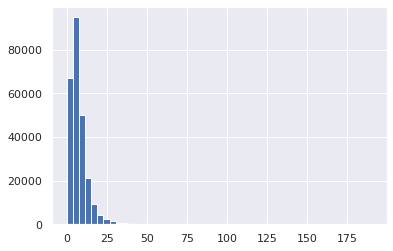

In [13]:
oof['error'].hist(bins=50)

(0.0, 40.0)

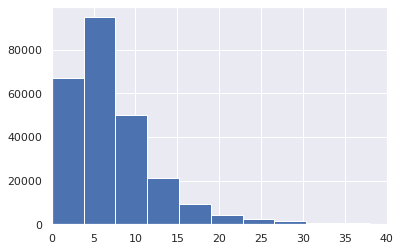

In [14]:
oof['error'].hist(bins=50)
plt.xlim(0,40)

(0.0, 200.0)

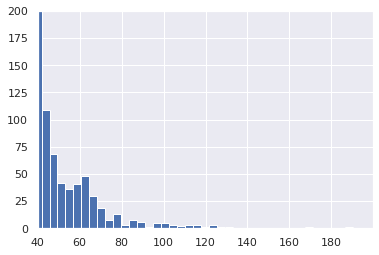

In [15]:
oof['error'].hist(bins=50)
plt.xlim(40,)
plt.ylim(0,200)

かなり外れているのもある
40以上の外れ値ってどうなっているの？どういうpathが存在している？

In [16]:
oof.loc[oof['error']>40, 'path']  # このpath消すってのもありかも

2170      5e15ab811506f2000638fe0d
5942      5d11943f9c50c70008fe8999
6046      5d11dbb7ffe23f0008604f35
6145      5d11dbc8ffe23f0008604f49
6782      5d10a1669c50c70008fe8977
                    ...           
245092    5dccedae757dea0006080310
245093    5dccedae757dea0006080310
248084    5dd79faf9191710006b567b1
248326    5dcd26cca4dbe7000630ae50
252137    5dcd5c89a4dbe7000630b086
Name: path, Length: 544, dtype: object

In [17]:
oof.loc[oof['error']>40, 'path'].nunique()

135

In [18]:
oof.loc[oof['error']>40, 'path'].value_counts().values  # 数はどれくらい

array([41, 40, 27, 19, 19, 13, 12, 12, 12, 10, 10, 10,  9,  9,  8,  8,  8,
        8,  8,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  5,  5,
        4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

pathごとに見てみると同一pathで全体的に外しているものが10個くらいある。path内のデータのうちどれくらいのデータが40オーバーになっているか調査する

<AxesSubplot:>

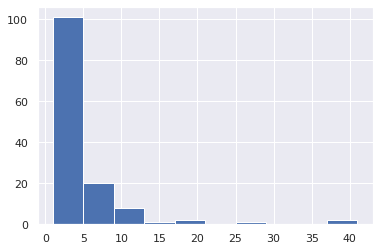

In [19]:
oof.loc[oof['error']>40, 'path'].value_counts().hist()

In [20]:
path = oof.loc[oof['error']>40, 'path'].value_counts().index
num_data_over40 = oof.loc[oof['error']>40, 'path'].value_counts().values
num_data = []
for i in path:
    num_data.append(len(oof[oof['path']==i]))

(array([99., 20.,  3.,  3.,  2.,  2.,  0.,  1.,  0.,  5.]),
 array([0.00205761, 0.10185185, 0.20164609, 0.30144033, 0.40123457,
        0.50102881, 0.60082305, 0.70061728, 0.80041152, 0.90020576,
        1.        ]),
 <BarContainer object of 10 artists>)

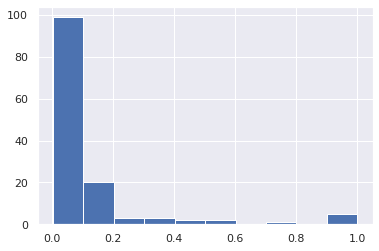

In [21]:
plt.hist(num_data_over40 / num_data)

path丸ごと外しているものもある

In [22]:
import json
import matplotlib.pylab as plt

def plot_preds(
    example,
    base=str(root_dir /'indoor-location-navigation'),
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    site = example.loc[0, 'site_id_str']
    map_floor = example.loc[0, 'floor_str']
    path = example.loc[0, 'path']
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f'site={site} | floor={map_floor} | path={path}', fontsize=15)
    plt.imshow(floor_img)


    example["x_"] = example["x"] * floor_img.shape[0] / height_meter
    example["y_"] = (example["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]


    example["oof_x_"] = example["oof_x"] * floor_img.shape[0] / height_meter
    example["oof_y_"] = (example["oof_y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]

    example.plot(
        x="x_",
        y="y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='target'
    )
    example.plot(
        x="oof_x_",
        y="oof_y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='oof'
    )
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5),fontsize=20
    )
    return fig, ax

In [23]:
np.where((num_data_over40 / num_data) > 0.5)  # 半分以上おかしいものを取得

(array([ 0,  2,  3, 14, 19, 20, 21, 26]),)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'site=5da1383b4db8ce0c98bc11ab | floor=F1 | path=5dd5216b50e04e0006f56476'}, xlabel='oof_x_'>)

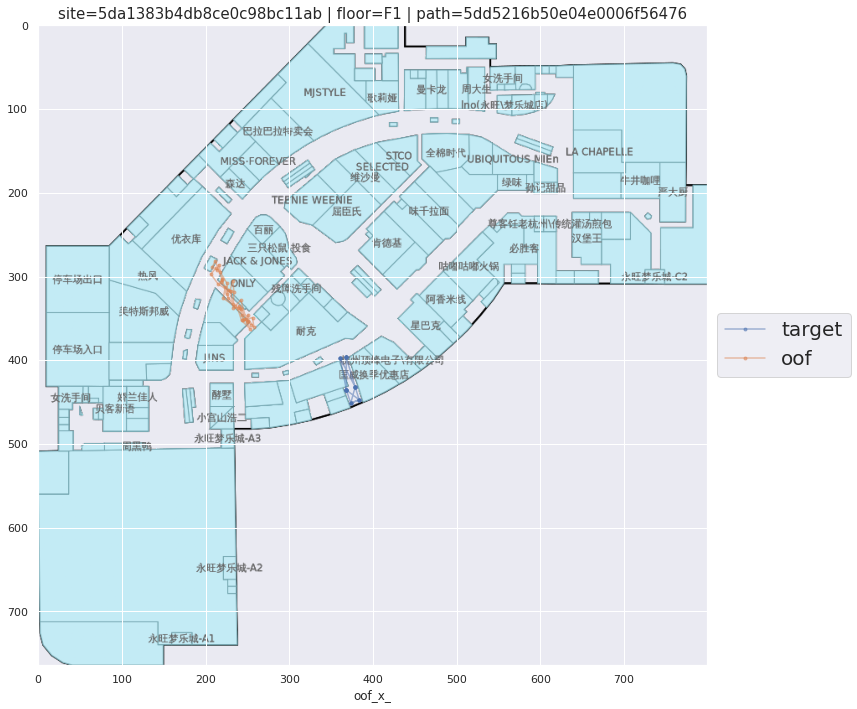

In [24]:
example = oof[oof['path']==path[0]].reset_index()
plot_preds(example)

Text(0, 0.5, 'error')

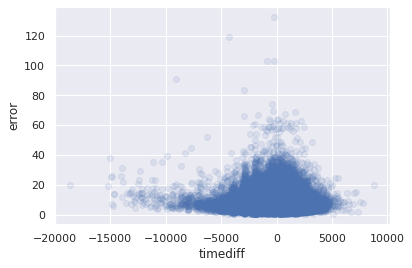

In [25]:
# 同じtimestampで平均を取った場合
df = pd.merge(oof.groupby('site_path_timestamp').mean(), train_df.groupby('site_path_timestamp')[['timediff']].mean(), how='left', on='site_path_timestamp')
x = df['timediff']
y = df['error']
plt.scatter(x,y, alpha=0.1)
plt.xlabel('timediff')
plt.ylabel('error')

In [26]:
train_df['error'] = oof['error']

In [54]:
TIMEDIFF_FEATS = [f'timediff_{i}' for i in range(80)]
RSSI_FEATS = [f'rssi_{i}' for i in range(80)]

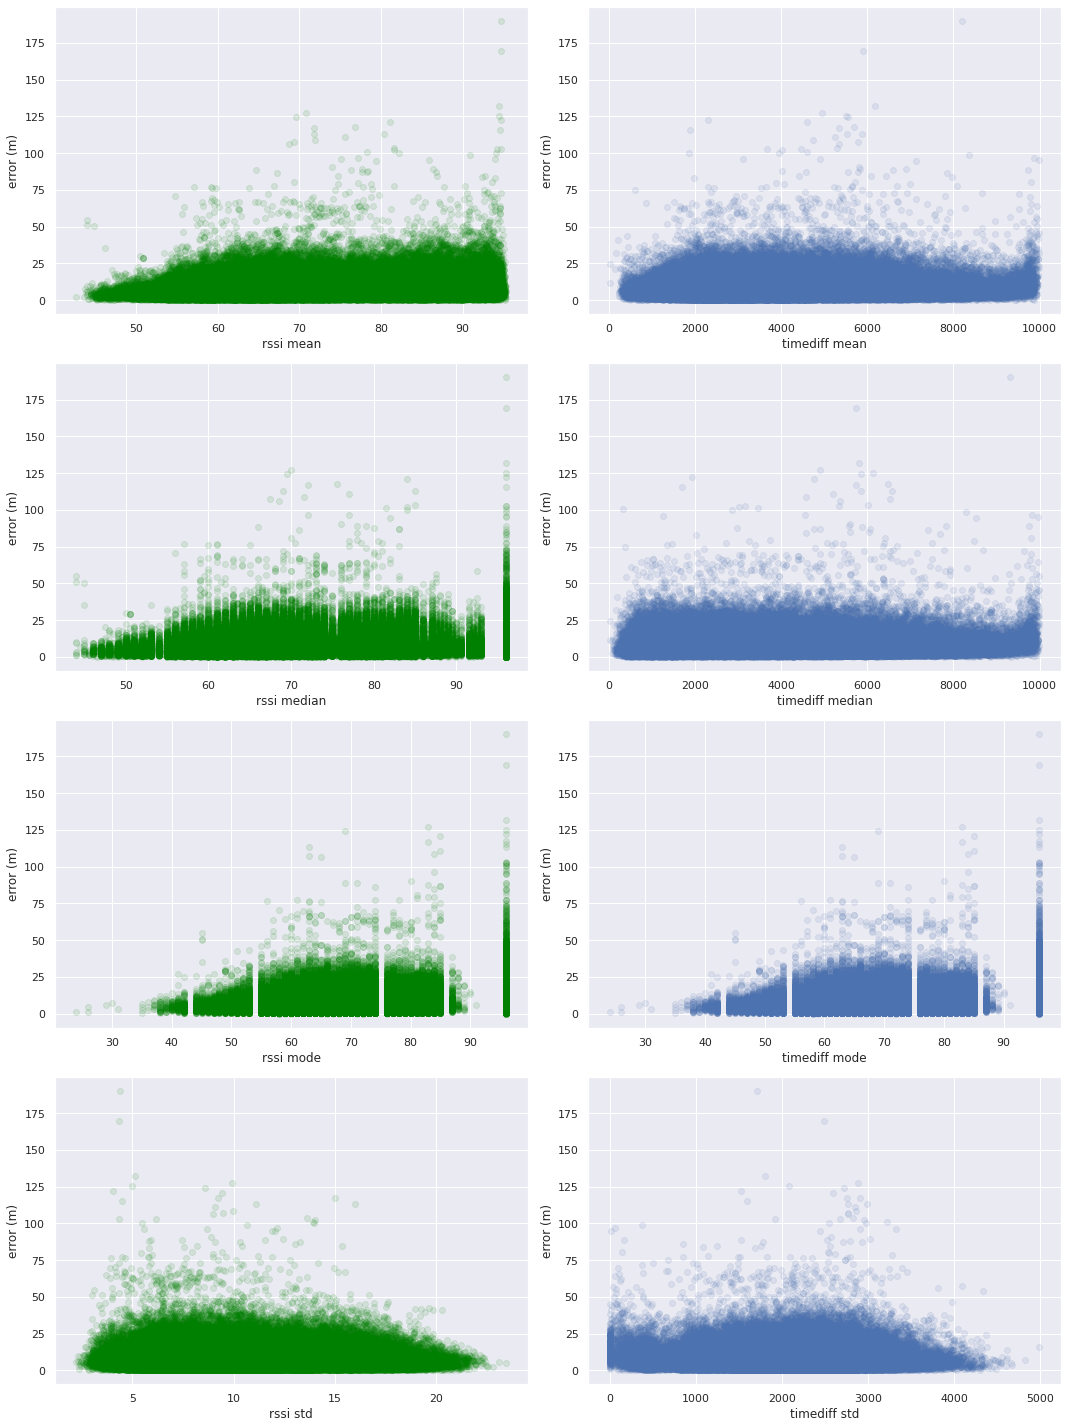

In [57]:
fig = plt.figure(figsize=(15,20))
y = oof['error'].values
for i, func in enumerate(['mean', 'median', 'mode', 'std']):
    for j, col_type in enumerate(['rssi', 'timediff']):
        ax = fig.add_subplot(4,2, (j+1) + 2*i)
        if col_type == 'rssi':
            col = RSSI_FEATS
            color = 'green'
        else:
            col = TIMEDIFF_FEATS
            color = None
        
        if func == 'mean':
            x = oof[col].mean(axis=1).values
        elif func == 'median':
            x = oof[col].median(axis=1).values
        elif func == 'mode':
            x = oof[RSSI_FEATS].mode(axis=1)[0].values
        else:
            x = oof[col].std(axis=1).values
        
        ax.scatter(x,y, alpha=0.1, color=color)
        ax.set_xlabel(f'{col_type} {func}')
        ax.set_ylabel('error (m)')
plt.tight_layout()
plt.savefig('all.png')
plt.show()

## データ数とエラーの関係を見てみる

In [63]:
oof['rssi_79'].value_counts()

96    103791
73      7526
72      7441
76      7401
74      7389
77      7026
71      6964
78      6919
79      6605
70      6535
80      6412
82      6328
81      6325
69      6310
83      6215
84      5965
68      5749
67      5466
85      5346
66      5074
65      4706
64      4189
63      3522
87      3357
62      2603
61      1940
88      1619
60      1240
59       717
89       664
58       387
90       251
57       243
56       209
55       152
53       113
52        56
51        24
50        11
91         4
47         3
49         3
92         3
40         2
48         2
39         2
45         1
94         1
37         1
Name: rssi_79, dtype: int64

In [79]:
# 96が欠損値を表す
num_nan = (oof[RSSI_FEATS]==96).sum(axis=1).values

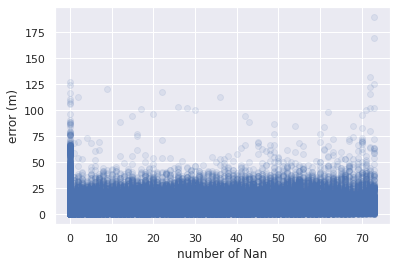

In [83]:
plt.scatter(num_nan, y, alpha=0.1)
plt.xlabel('number of Nan')
plt.ylabel('error (m)')
plt.savefig('nan.png')